# HTML Parser for the Croma dataset

## load the feature and data extreaction libraries

In [2]:
import json
import pandas as pd
import os
from bs4 import BeautifulSoup
import seaborn as sns

## Create a function for collecting HTML from Json

In [1]:
def json_reader(json_file):
    f=open(json_file)
    json_info = json.load(f)
    html_info = []
    for i in json_info:
        section=i
        html_data= section.get('html')
        html_info.append(html_data)
    return html_info

## Create a function to collected the tables and conusmer informaiton from the HTML

In [3]:
def clean_capture(web_html_file):
    #Capture tables from web
    soup = BeautifulSoup(web_html_file,'lxml')
    keywords = soup.find_all("table")[0].find_all("tr")[1:]
    keyword_data = []
    
    #Collect the information about the consumer shopping
    for element in keywords:
        sub_data=[]
        for sub_element in element:
            try:
                sub_data.append(sub_element.get_text())
            except:
                continue
        keyword_data.append(sub_data)
        
    
    #Clean the final keyword dataset
    final_data=[]
    for value in keyword_data:
        if len(value)>1:
            final_data.append(value)
            
    
    return final_data

## Create a funciton to clean the text and load the informaiton into new dictionary 

In [4]:
def create_dict(clean_text):
    #Define dictionary
    dictnory ={'product_name':[],'qty':[], 'location':[],'payment_mode':[],'price':[]}
    #bad char remove part
    bad_char = [':',';','*','₹',',','\xa0']
    for i in range(len(clean_text)):
        text = clean_text[i]
        
        #load the information about the product detailed and qty and price
        if len(text)==4:
            if text[0] !='Product Name':
                #Load the information about product name
                product= clean_text[i]
                dictnory['product_name'].append(product[0])
                #Qty orderd
                qty = product[1]
                dictnory['qty'].append(int(qty))
                
                #Price of product
                price = product[2]
                for bd in bad_char:
                    price=price.replace(bd,'')
                dictnory['price'].append(float(price))
        
        #Add information about the Location         
        elif text[0] =='Billing Address':
            add = clean_text[i+1]
            dictnory['location'].append(int(add[0][-7:]))
            if text[1] =='Payment mode':
                dictnory['payment_mode'].append(add[1])
            
        elif text[0] == 'Order Summary':
            add  = clean_text[i+1]
            dictnory['location'].append(add[1][-14:-8])
            dictnory['payment_mode'].append(add[2])
            
    mumbai=400004
    if len(dictnory['location'])<1:
        dictnory['location'] =mumbai
    if len(dictnory['payment_mode'])<1:
        dictnory['payment_mode'] ='Credit Card'         
    #Create a dataframe
    for i in range(len(dictnory['product_name'])-1):
        dictnory['location'].append(dictnory['location'][0])
        dictnory['payment_mode'].append(dictnory['payment_mode'][0])
        
    df = pd.DataFrame(dictnory)
    return df

## Create a function to collecte the informaiton in dataframe

In [5]:
def dataframe_creation(web_dictonary):
    consumer_df =[]
    for i in web_dictonary:
        if len(i)>1000:
            clean_info =clean_capture(i)
            dic =create_dict(clean_info)
            consumer_df.append(dic)
            
    final_df = pd.concat(consumer_df,axis=0,ignore_index=True)
    return final_df

## Load the Json file and collected the consumer informaiton in the dataframe

In [6]:
final_df = []
data_files = [fname for fname in os.listdir('croma_inter/')]
for i in data_files:
    location = ('croma_inter/'+i)
    web_info = json_reader(location)
    df_intial= dataframe_creation(web_info)
    df_intial['Time']=location[12:30]
    final_df.append(df_intial)
    
Croma_df = pd.concat(final_df, axis=0, ignore_index=True)

In [27]:
Croma_df

,product_name,qty,location,payment_mode,price,Time
0,Western Digital My Passport 2TB USB 3.2 Ha...,1.0,560003,Payment Mode GiftCard/Voucher / UPI,5199.0,year-2021_month-05
1,"Apple iPad Pro Wi-Fi 27.94 cm (11 inch), S...",1.0,492002,Payment Mode Debit Card,72890.0,year-2021_month-05
2,"Apple Pencil 2nd Generation (MU8F2ZM/A, Wh...",1.0,492002,Payment Mode Debit Card,10900.0,year-2021_month-05
3,Asus TUF 68.58cm (27 Inches) Full HD IPS G...,1.0,110063,Payment Mode Debit Card,34990.0,year-2021_month-05
4,Panasonic 1.8 Litres Rice Cooker (SR-WA18H...,1.0,570021,Payment Mode Debit Card,1799.0,year-2021_month-05
...,...,...,...,...,...,...
387,Borosil Klip-N-Store 520 ml Square Storage Con...,1.0,500050,GiftCard/Voucher / UPI,309.0,year-2022_month-01
388,Spigen Liquid Crystal TPU Back Case For iPhone...,1.0,560085,Pay by UPI,570.0,year-2022_month-01
389,Haier 20 Litres Convection Microwave Oven (HIL...,1.0,560114,Credit Card,8750.0,year-2022_month-01
390,Roxx Pro 2 Piece Bowl Kit (Provided with Haier...,1.0,560114,Credit Card,490.0,year-2022_month-01


## Store the file in .CSV

In [8]:
Croma_df.to_csv('croma_consumer_info.csv')

## Test if the zipcode informaiton is valid or not

In [12]:
zip_code = Croma_df['location'][14]

In [13]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent='geoapiExerciises')
location=geolocator.geocode(zip_code)
print(location)

Indore Tahsil, Indore District, Madhya Pradesh, 452001, India


## Data visulisaiton on type of payment methods used by consumers

In [11]:
import matplotlib.pyplot as plt
from matplotlib import style

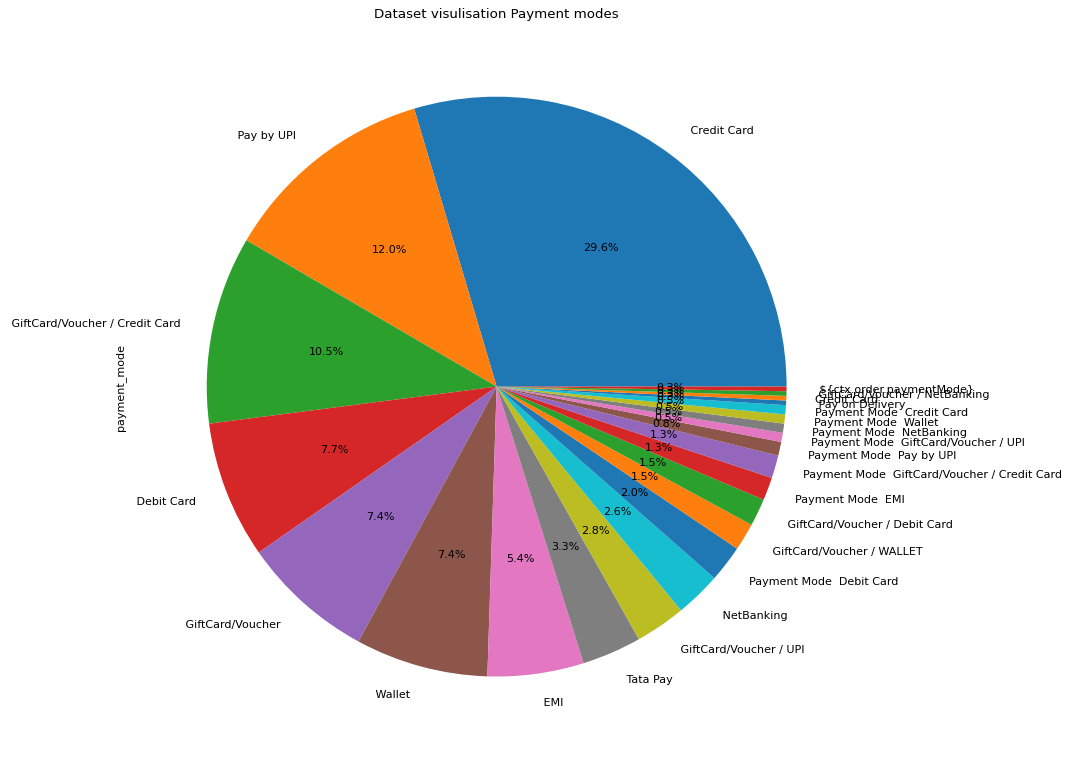

In [14]:
Y_data = Croma_df['payment_mode']
#Data visulisation of samples in each class
plt.figure(figsize=(16,12),dpi=80,)
plt.title('Dataset visulisation Payment modes')
zz=Y_data.value_counts().plot(kind='pie', autopct = '%1.1f%%')
plt.tick_params(axis='x',labelsize=14)
plt.tick_params(axis='y',labelsize=14)
plt.grid(which='major',color='y', linestyle='--')
plt.show()

## Monthy data analysis for each location

### May month sales analysis

In [66]:
test = final_df[0]
a = test.groupby('payment_mode')['payment_mode'].count()
print(a)
test = final_df[0]
a = test.groupby(['payment_mode','location'])
a.first()

payment_mode
Credit Card                                       1
Payment Mode  Credit Card                         2
Payment Mode  Debit Card                          7
Payment Mode  EMI                                 5
Payment Mode  GiftCard/Voucher / Credit Card      5
Payment Mode  GiftCard/Voucher / UPI              2
Payment Mode  NetBanking                          2
Payment Mode  Pay by UPI                          3
Payment Mode  Wallet                              2
Name: payment_mode, dtype: int64


product_name  \
payment_mode                                   location                                                      
Credit Card                                    400004        Samsung Galaxy M02s (64GB ROM, 4GB RAM, SM...   
Payment Mode  Credit Card                      201303        Safestab Stabilizer for Inverter AC (VST40...   
                                               400092        Croma FireTV Edition 109cm (43 Inch) Ultra...   
Payment Mode  Debit Card                       110058        Inbase Tempered Glass Screen Protector For...   
                                               110063        Asus TUF 68.58cm (27 Inches) Full HD IPS G...   
                                               364002        Samsung Galaxy A51 (128GB ROM, 6GB RAM, SM...   
                                               492002        Apple iPad Pro Wi-Fi 27.94 cm (11 inch), S...   
                                               560030                 Sony Headphone MDR-ZX110/B Black       
                                               570021        Panasonic 1.8 Litres Rice Cooker (SR-WA18H...   
Payment Mode  EMI                              201303        Hitachi Kaze Plus 1.5 Ton 3 Star Window AC...   
                                               395009        Samsung Galaxy A52 (128GB ROM, 6GB RAM, SM...   
                                               452001        Dell Inspiron 3505 (D560390WIN9SL) Ryzen 5...   
                                               560004        Apple MacBook Air (MGN63HN/A) M1 Chip macO...   
                                               560035        Apple iPhone 12 Pro Max (128GB ROM, 6GB RA...   
Payment Mode  GiftCard/Voucher / Credit Card   122003        Sony Playstation 5 825GB SSD (CFI-1008A01R...   
                                               400092        Croma FireTV Edition 109cm (43 Inch) Ultra...   
                                               411061        Samsung Galaxy M02s (64GB ROM, 4GB RAM, SM...   
                                               500052        Travel Blue Tranquillity Neck Pillow (XL -...   
Payment Mode  GiftCard/Voucher / UPI           458001        Croma Kube 5 Watts Portable Bluetooth Spea...   
                                               560003        Western Digital My Passport 2TB USB 3.2 Ha...   
Payment Mode  NetBanking                       421203        Faber 1000 m³/hr 60cm Wall Mount Chimney (...   
                                               695017        Philips EasySpeed 1400 Watts Steam Iron (F...   
Payment Mode  Pay by UPI                       390019             Croma Wireless Mouse (XM5106, Black)       
                                               431005        Glen 1038 GT 3 Burner Toughened Glass Gas ...   
                                               560064        Sony Playstation 5 825GB SSD (CFI-1008A01R...   
Payment Mode  Wallet                           400067        Bajaj 67 Litres Room Air Cooler (Honeycomb...   

                                                         qty     price  \
payment_mode                                   location                  
Credit Card                                    400004    1.0    9999.0   
Payment Mode  Credit Card                      201303    1.0    2499.0   
                                               400092    1.0   34999.0   
Payment Mode  Debit Card                       110058    1.0     499.0   
                                               110063    1.0   34990.0   
                                               364002    1.0   20999.0   
                                               492002    1.0   72890.0   
                                               560030    1.0     899.0   
                                               570021    1.0    1799.0   
Payment Mode  EMI                              201303    1.0   26500.0   
                                               395009    1.0   26499.0   
                                               4520

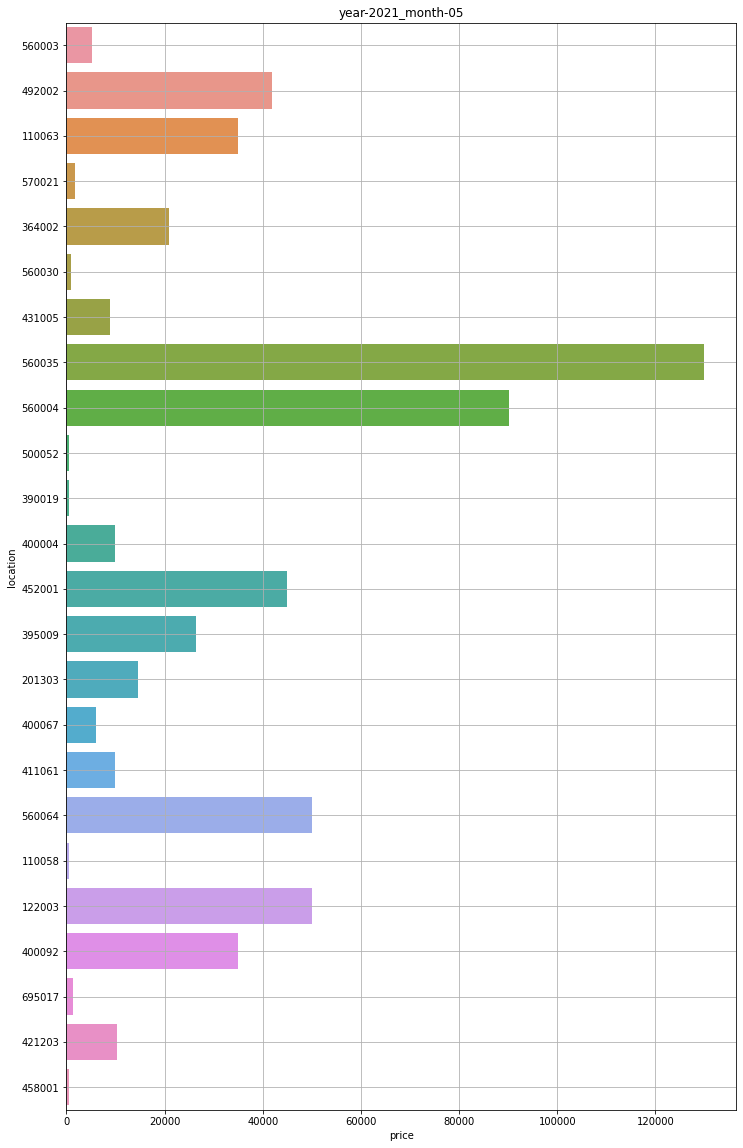

In [15]:
test = final_df[0]
a = test['price']
b = test['location']
plt.figure(figsize=(12,20))
g =sns.barplot(x=a, y=b, data=test, ci=None).set(title=test['Time'][0])
plt.grid()

### June month sales analysis

In [65]:
test = final_df[1]
a = test.groupby('payment_mode')['payment_mode'].count()
print(a)
test = final_df[1]
a = test.groupby(['payment_mode','location'])
a.first()

payment_mode
 Credit Card                        6
 Debit Card                         4
 EMI                                3
 GiftCard/Voucher                   1
 GiftCard/Voucher / Credit Card     2
 GiftCard/Voucher / UPI             4
 Pay by UPI                         3
 Wallet                             3
Payment Mode  Debit Card            1
Name: payment_mode, dtype: int64


product_name  \
payment_mode                     location                                                      
 Credit Card                     121003    Samsung Galaxy Note 10 Lite S View Carbon Fibe...   
                                 302022    Logitech HD Webcam (Plug and Play Video Callin...   
                                 364320    Whirlpool 200 Litres 3 Star Direct Cool Single...   
                                 400072    Sony Playstation 5 825GB SSD (CFI-1008A01R, Wh...   
                                 400088    Amazfit Bip U Smart Watch (GPS) (Large Color S...   
 Debit Card                      201012    Apple Airpods Pro In-Ear Truly Wireless Earbud...   
                                 509210    Lenovo IdeaPad 3 15IIL05 (81WE007XIN) Core i5 ...   
                                 600106    Amazfit Bip U Smart Watch (GPS) (Large Color S...   
                                 603002    Daikin 1 Ton 5 Star Inverter Split AC (Copper ...   
 EMI                             110093    Dell Inspiron 3505 (D560280WIN9SL) Ryzen 5 Win...   
                                 600061    Croma 1 Ton 3 Star Split AC (CRAC7721, Copper ...   
                                 700086    Sony Playstation 5 825GB SSD (CFI-1008A01R, Wh...   
 GiftCard/Voucher                455001    Boat Airdopes 443 In-Ear Truly Wireless Earbud...   
 GiftCard/Voucher / Credit Card  160062       Apple Pencil 2nd Generation (MU8F2ZM/A, White)   
                                 600041    Philips Viva Collection Air Fryer (Fat Removal...   
 GiftCard/Voucher / UPI          133001    Kuvings 240 Watts 1 Blade Cold Press Slow Juic...   
                                 500049    Panasonic Warmer 1.8 Litres Electric Rice Cook...   
 Pay by UPI                      110027    Realme C15 (32GB ROM, 3GB RAM, RMX2180, Power ...   
                                 577418    Philips Multigroom Series 7000 Self-sharpening...   
                                 700006    Vivo V20 Pro (128GB ROM, 8GB RAM, PD2020F_IN, ...   
 Wallet                          400058    Ultraprolink Retro Portable Bluetooth Speaker ...   
                                 421306    HP DeskJet 2729 Wireless Color All-in-One Inkj...   
                                 641022    Realme Buds 2 In-Ear Wired Earphones with Mic ...   
Payment Mode  Debit Card         411009        Croma 10000mAh 2-Port Power Bank (Recharge...   

                                           qty    price                Time  
payment_mode                     location                                    
 Credit Card                     121003      1   1494.0  year-2021_month-06  
                                 302022      1   1999.0  year-2021_month-06  
                                 364320      1  16490.0  year-2021_month-06  
                                 400072      1  49990.0  year-2021_month-06  
                                 400088      1   3999.0  year-2021_month-06  
 Debit Card                      201012      1  21490.0  year-2021_month-06  
                                 509210      1  52990.0  year-2021_month-06  
                                 600106      1   3999.0  year-2021_month-06  
                                 603002      1  39500.0  year-2021_month-06  
 EMI                             110093      1  47990.0  year-2021_month-06  
                                 600061      1  24990.0  year-2021_month-06  
                                 700086      1  49990.0  year-2021_month-06  
 GiftCard/Voucher                455001      1   2499.0  year-2021_month-06  
 GiftCard/Voucher / Credit Card  160062      1  10900.0  year-2021_month-06  
                                 600041      1  10999.0  year-2021_month-06  
 GiftCard/Voucher / UPI          133001      1  17690.0  year-2021_month-06  
                                 500049      1   2599.0  year-2021_month-06  
 Pay by UPI                      110027      1   8999.0  year-2021_month-06  
                       

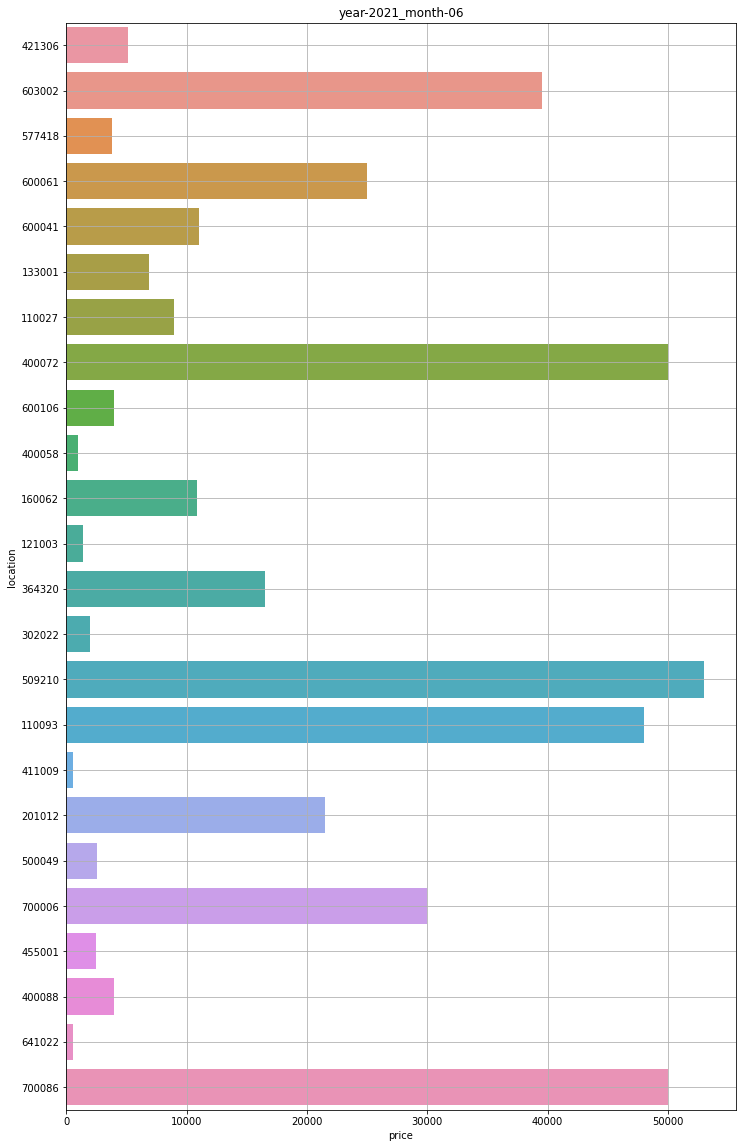

In [16]:
test = final_df[1]
a = test['price']
b = test['location']
plt.figure(figsize=(12,20))
g =sns.barplot(x=a, y=b, data=test, ci=None).set(title=test['Time'][0])
plt.grid()

### July month sales analysis

In [64]:
test = final_df[2]
a = test.groupby('payment_mode')['payment_mode'].count()
print(a)
test = final_df[2]
a = test.groupby(['payment_mode','location'])
a.first()

payment_mode
 Credit Card                        7
 Debit Card                         2
 EMI                                2
 GiftCard/Voucher                   6
 GiftCard/Voucher / Credit Card     4
 GiftCard/Voucher / Debit Card      1
 GiftCard/Voucher / UPI             2
 GiftCard/Voucher / WALLET          2
 Pay by UPI                         4
 Wallet                             1
Name: payment_mode, dtype: int64


product_name  \
payment_mode                     location                                                      
 Credit Card                     382481    Samsung Galaxy S20 FE (128GB ROM, 8GB RAM, G78...   
                                 410403    Samsung 192 Litres 3 Star Direct Cool Inverter...   
                                 411041    Amazfit Bip U Smart Watch (GPS) (Large Color S...   
                                 452018    Seagate Backup Plus Slim Portable 2TB USB 3.0 ...   
                                 500008    Samsung Galaxy A72 (128GB ROM, 8GB RAM, SM-A72...   
                                 533103    Samsung 23 litres Solo Microwave Oven (MS23K35...   
 Debit Card                      110085    HP Smart Tank 516 Wireless Color All-in-One In...   
                                 144001    Apple Airpods In-Ear Truly Wireless Earbuds wi...   
 EMI                             400104    HP 14s-dq2101TU (38Z17PA#ACJ) Core i3 11th Gen...   
                                 700017    Apple iPhone 11 (128GB ROM, 4GB RAM, MHDJ3HN/A...   
 GiftCard/Voucher                455001    Boat Rockerz255R In-Ear Wireless Earphones wit...   
                                 842002    OnePlus Smart Band (40.4mm) (Step Count, W101N...   
 GiftCard/Voucher / Credit Card  110025      Sony In-Ear Wireless Earphones (WI-C310, Black)   
                                 560085    Havells Supersonic 5-in-1 Corded Multi Styling...   
                                 570018    Amazfit GTS 2 Mini Smart Watch (GPS) (Always-o...   
 GiftCard/Voucher / Debit Card   700086    Panasonic Warmer 1.8 Litres Electric Rice Cook...   
 GiftCard/Voucher / UPI          334402    Xiaomi Mi Band 3i Fitness Tracker (19.8mm) (3 ...   
 GiftCard/Voucher / WALLET       500050        ORB PS4 Controller Silicone Skin Cover (Blue)   
 Pay by UPI                      110062    Philips Daily Collection 300 Watts Hand Mixer ...   
                                 144001    Apple iPad Pro 11 3rd Gen WiFi iOS Tablet (iPa...   
                                 400050    Apple 2 Meter USB 3.0 (Type-C) to USB 3.0 (Typ...   
                                 560026    boAt Airdopes 138 In-Ear Truly Wireless Earbud...   
 Wallet                          560060    Go Pro 3.5 mm USB-C Power Mic Adapter (AAMIC-0...   

                                           qty    price                Time  
payment_mode                     location                                    
 Credit Card                     382481      1  37999.0  year-2021_month-07  
                                 410403      1  13990.0  year-2021_month-07  
                                 411041      1   3999.0  year-2021_month-07  
                                 452018      1   5499.0  year-2021_month-07  
                                 500008      1  34999.0  year-2021_month-07  
                                 533103      1   5999.0  year-2021_month-07  
 Debit Card                      110085      1  15499.0  year-2021_month-07  
                                 144001      1  12490.0  year-2021_month-07  
 EMI                             400104      1  39990.0  year-2021_month-07  
                                 700017      1  54499.0  year-2021_month-07  
 GiftCard/Voucher                455001      1   1299.0  year-2021_month-07  
                                 842002      1   2499.0  year-2021_month-07  
 GiftCard/Voucher / Credit Card  110025      1   2190.0  year-2021_month-07  
                                 560085      1   2599.0  year-2021_month-07  
                                 570018      1   6999.0  year-2021_month-07  
 GiftCard/Voucher / Debit Card   700086      1   2599.0  year-2021_month-07  
 GiftCard/Voucher / UPI          334402      1    794.0  year-2021_month-07  
 GiftCard/Voucher / WALLET       500050      1    299.0  year-2021_month-07  
 Pay by UPI                      110062      1   2149.0  year-2021_month-07  
                                 144001  

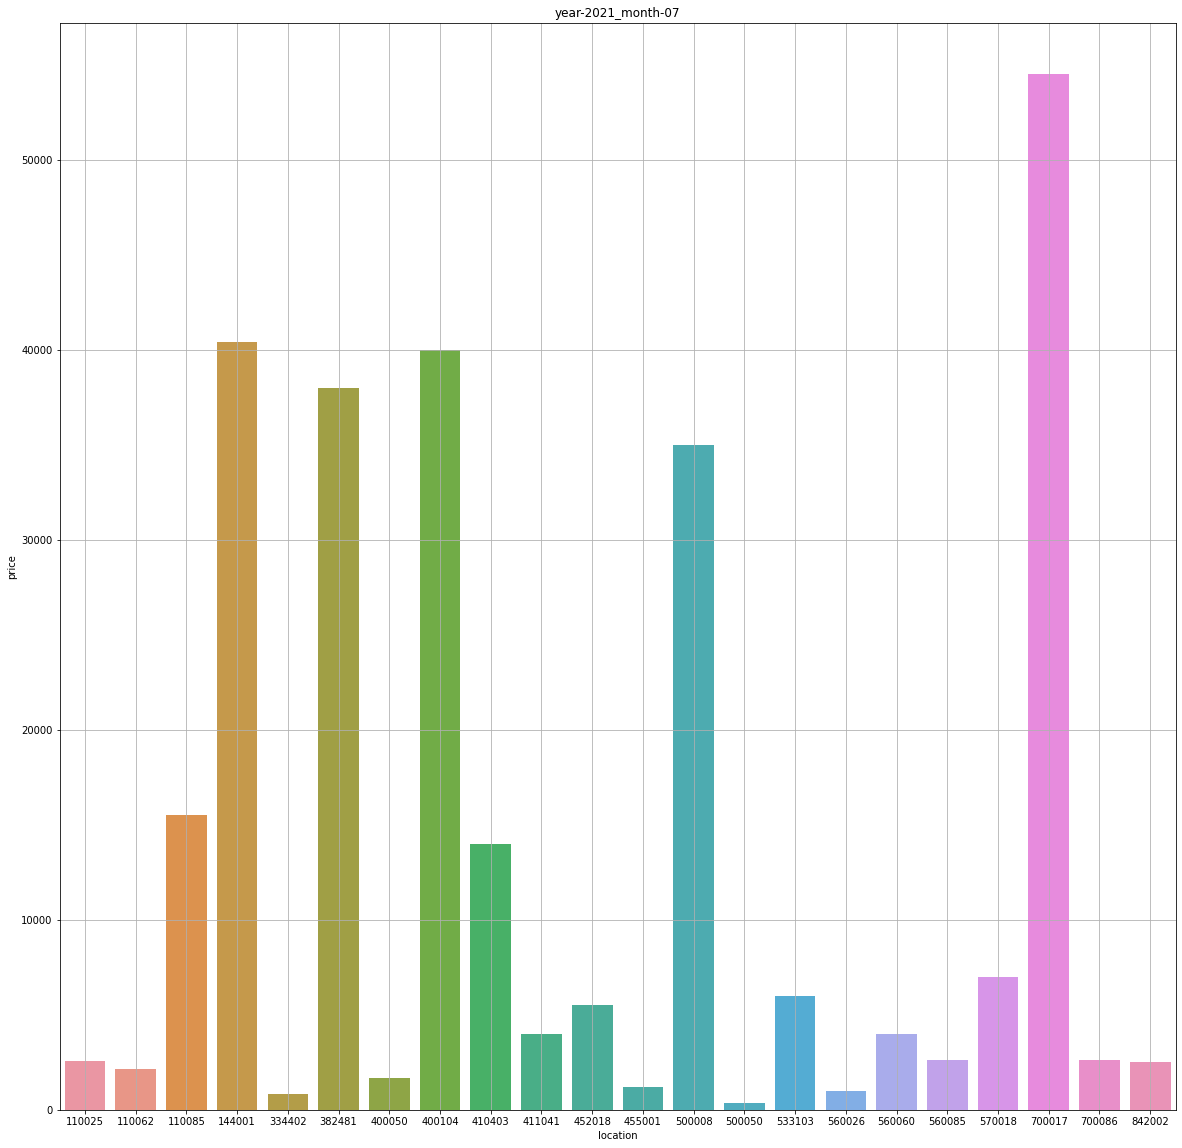

In [17]:
test = final_df[2]
a = test['price']
b = test['location']
plt.figure(figsize=(20,20))
g =sns.barplot(x=b, y=a, data=test, ci=None).set(title=test['Time'][0])
plt.grid()

### August month sales analysis

In [63]:
test = final_df[3]
a = test.groupby('payment_mode')['payment_mode'].count()
print(a)
test = final_df[3]
a = test.groupby(['payment_mode','location'])
a.first()

payment_mode
 Credit Card                        11
 Debit Card                          4
 EMI                                 1
 GiftCard/Voucher                    2
 GiftCard/Voucher / Credit Card      4
 GiftCard/Voucher / WALLET           1
 NetBanking                          2
 Pay by UPI                          2
 Wallet                              1
Name: payment_mode, dtype: int64


product_name  \
payment_mode                     location                                                      
 Credit Card                     302015    OnePlus Nord 2 5G (128GB ROM, 8GB RAM, DN2101,...   
                                 400002    HP 15s-gr0012AU (35K35PA#ACJ) Ryzen 3 Windows ...   
                                 403110    Samsung 8 kg 5 Star Fully Automatic Front Load...   
                                 411033    Apple iPad Pro 11 3rd Gen WiFi iOS Tablet (iPa...   
                                 560102    Bajaj Pygmy Mini 11cm Sweep 3 Blade Table Fan ...   
                                 600053    Panasonic Cordless Landline Phone (KX-TG3611BX...   
 Debit Card                      110084    boAt Airdopes 138 In-Ear Truly Wireless Earbud...   
                                 421302    Croma 10000mAh 2-Port Power Bank (18 Months Wa...   
                                 421501    Balzano Nutriblender 1200 Watts Mixer Grinder ...   
                                 600015    Microsoft Office 365 Home for PC and Mac (6 Us...   
 EMI                             560099    Oppo A53s (128GB ROM, 8GB RAM, CPH2321, Ink Bl...   
 GiftCard/Voucher                473001    Xiaomi Redmi In-Ear Wired Earphone with Mic (I...   
                                 825314    boAt In-Ear Wired Earphones with Mic (BassHead...   
 GiftCard/Voucher / Credit Card  160062       Boat Bluetooth Earphones (Rockerz 255R, Black)   
                                 388120    Dr. Odin LCD Blood Pressure Monitor (Auto Powe...   
                                 411017    OnePlus Nord CE 5G (256GB ROM, 12GB RAM, Silve...   
 GiftCard/Voucher / WALLET       473001    Syska Stainless Steel Blades Cordless Operatio...   
 NetBanking                      400706         Croma 5 Way Surge Protector (CRCP1002, Blue)   
                                 500035    Philips 2.1 Channel Multimedia Speaker (MMS262...   
 Pay by UPI                      380015    Fire-Boltt 13BWHAAY#1 Over-Ear Wired Headphone...   
                                 700120    Samsung Galaxy Tab S6 Lite WiFi Android Tablet...   
 Wallet                          302022    Realme Buds 2 Wired Earphones (ACCFKYE2ARGG67W...   

                                           qty    price                Time  
payment_mode                     location                                    
 Credit Card                     302015      1  29999.0  year-2021_month-08  
                                 400002      1  40990.0  year-2021_month-08  
                                 403110      1  36790.0  year-2021_month-08  
                                 411033      1  71900.0  year-2021_month-08  
                                 560102      1    899.0  year-2021_month-08  
                                 600053      1   1999.0  year-2021_month-08  
 Debit Card                      110084      1    999.0  year-2021_month-08  
                                 421302      1    599.0  year-2021_month-08  
                                 421501      1   5490.0  year-2021_month-08  
                                 600015      1   4504.0  year-2021_month-08  
 EMI                             560099      1  17990.0  year-2021_month-08  
 GiftCard/Voucher                473001      1    399.0  year-2021_month-08  
                                 825314      1    399.0  year-2021_month-08  
 GiftCard/Voucher / Credit Card  160062      1    899.0  year-2021_month-08  
                                 388120      1   1290.0  year-2021_month-08  
                                 411017      1  27999.0  year-2021_month-08  
 GiftCard/Voucher / WALLET       473001      1    600.0  year-2021_month-08  
 NetBanking                      400706      2   2180.0  year-2021_month-08  
                                 500035      1   2999.0  year-2021_month-08  
 Pay by UPI                      380015      1   1299.0  year-2021_month-08  
                                 700120      1  27999.0  ye

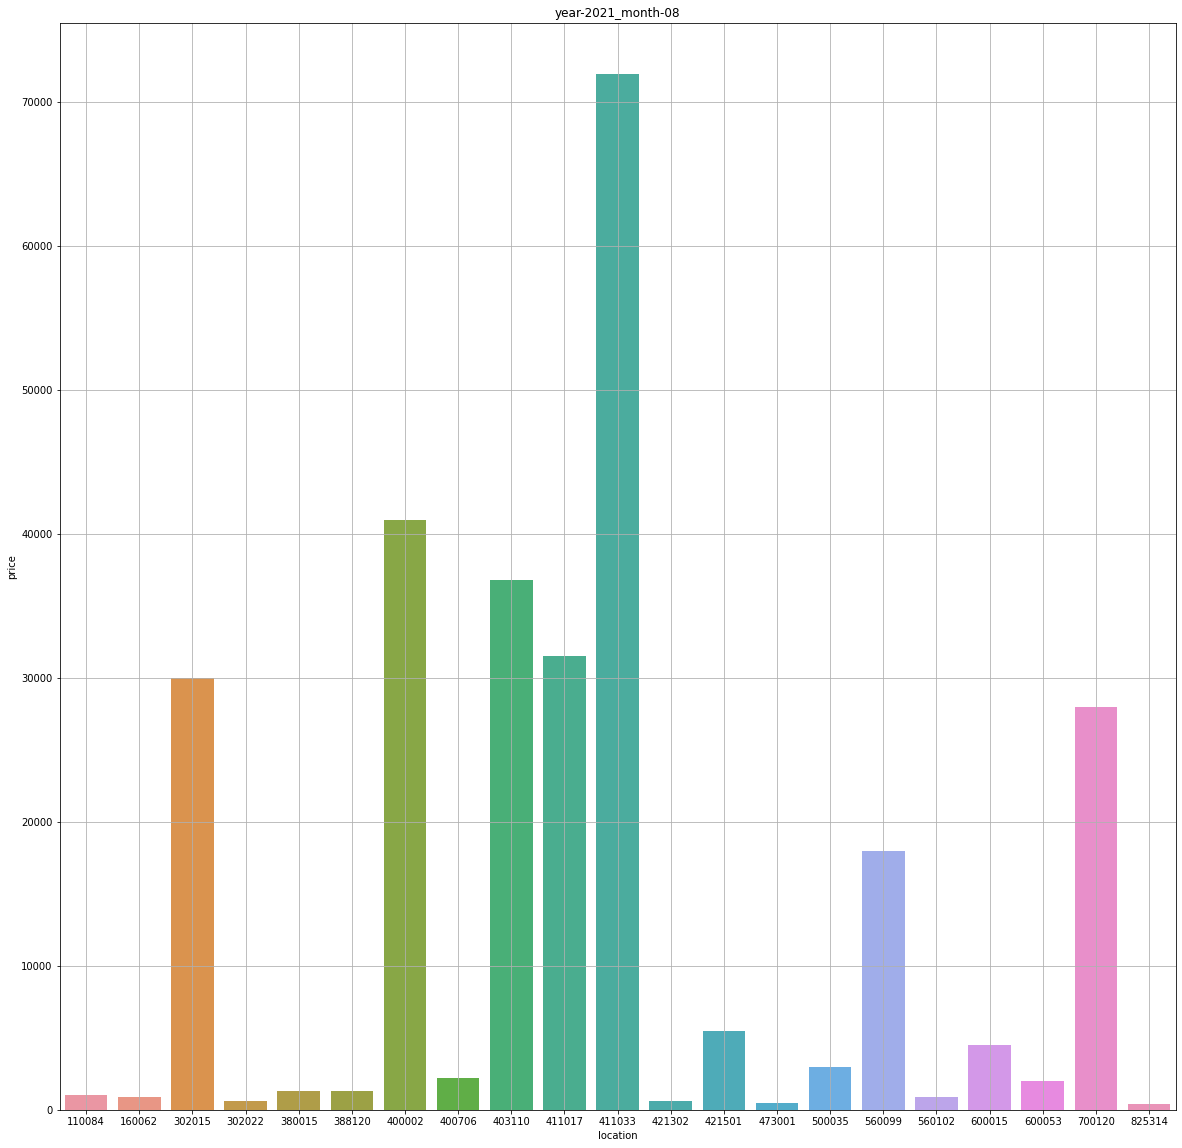

In [18]:
test = final_df[3]
a = test['price']
b = test['location']
plt.figure(figsize=(20,20))
g =sns.barplot(x=b, y=a, data=test, ci=None).set(title=test['Time'][0])
plt.grid()

### September month sales analysis

In [61]:
test = final_df[4]
a = test.groupby('payment_mode')['payment_mode'].count()
print(a)
test = final_df[4]
a = test.groupby(['payment_mode','location'])
a.first()

payment_mode
 Credit Card                        2
 Debit Card                         1
 EMI                                2
 GiftCard/Voucher                   1
 GiftCard/Voucher / Credit Card     4
 NetBanking                         2
 Pay by UPI                         3
 Wallet                             2
Name: payment_mode, dtype: int64


product_name  \
payment_mode                     location                                                      
 Credit Card                     411017    OnePlus Cobalt Limited Edition Smart Watch (GP...   
 Debit Card                      122010    OnePlus In-Ear Truly Wireless Earbuds with Mic...   
 EMI                             500035    Sony Playstation 4 1TB (CUH-2208B, Black) with...   
                                 560035    Apple iPhone 13 Pro (128GB ROM, 6GB RAM, MLVD3...   
 GiftCard/Voucher                500049    Tp-Link AC1200 Dual Band Wireless Router (Arch...   
 GiftCard/Voucher / Credit Card  110001    OnePlus Buds Z In-Ear Truly Wireless Earbuds w...   
                                 110045    Xiaomi Mi 20000mAh 3-Port Power Bank (Li-ion B...   
 NetBanking                      500072    Apple iPhone 13 Pro (256GB ROM, 6GB RAM, MLVP3...   
 Pay by UPI                      110019    Apple Airpods In-Ear Truly Wireless Earbuds wi...   
                                 110092    Philips PerfectCare 2400 Watt Steam Iron (Opti...   
                                 201301    Realme Buds Air 2 In-Ear Active Noise Cancella...   
 Wallet                          380061    Realme 8i (64GB ROM, 4GB RAM, RMX3151, Space B...   
                                 422101    Xiaomi Redmi 9 Power (64GB ROM, 4GB RAM, MZB08...   

                                           qty     price                Time  
payment_mode                     location                                     
 Credit Card                     411017      1   19999.0  year-2021_month-09  
 Debit Card                      122010      1    9990.0  year-2021_month-09  
 EMI                             500035      1   29990.0  year-2021_month-09  
                                 560035      1  119900.0  year-2021_month-09  
 GiftCard/Voucher                500049      1    1999.0  year-2021_month-09  
 GiftCard/Voucher / Credit Card  110001      1    2999.0  year-2021_month-09  
                                 110045      1    1699.0  year-2021_month-09  
 NetBanking                      500072      1  129900.0  year-2021_month-09  
 Pay by UPI                      110019      1   12990.0  year-2021_month-09  
                                 110092      1    7299.0  year-2021_month-09  
                                 201301      1    3299.0  year-2021_month-09  
 Wallet                          380061      1   13999.0  year-2021_month-09  
                                 422101      1   11999.0  year-2021_month-09

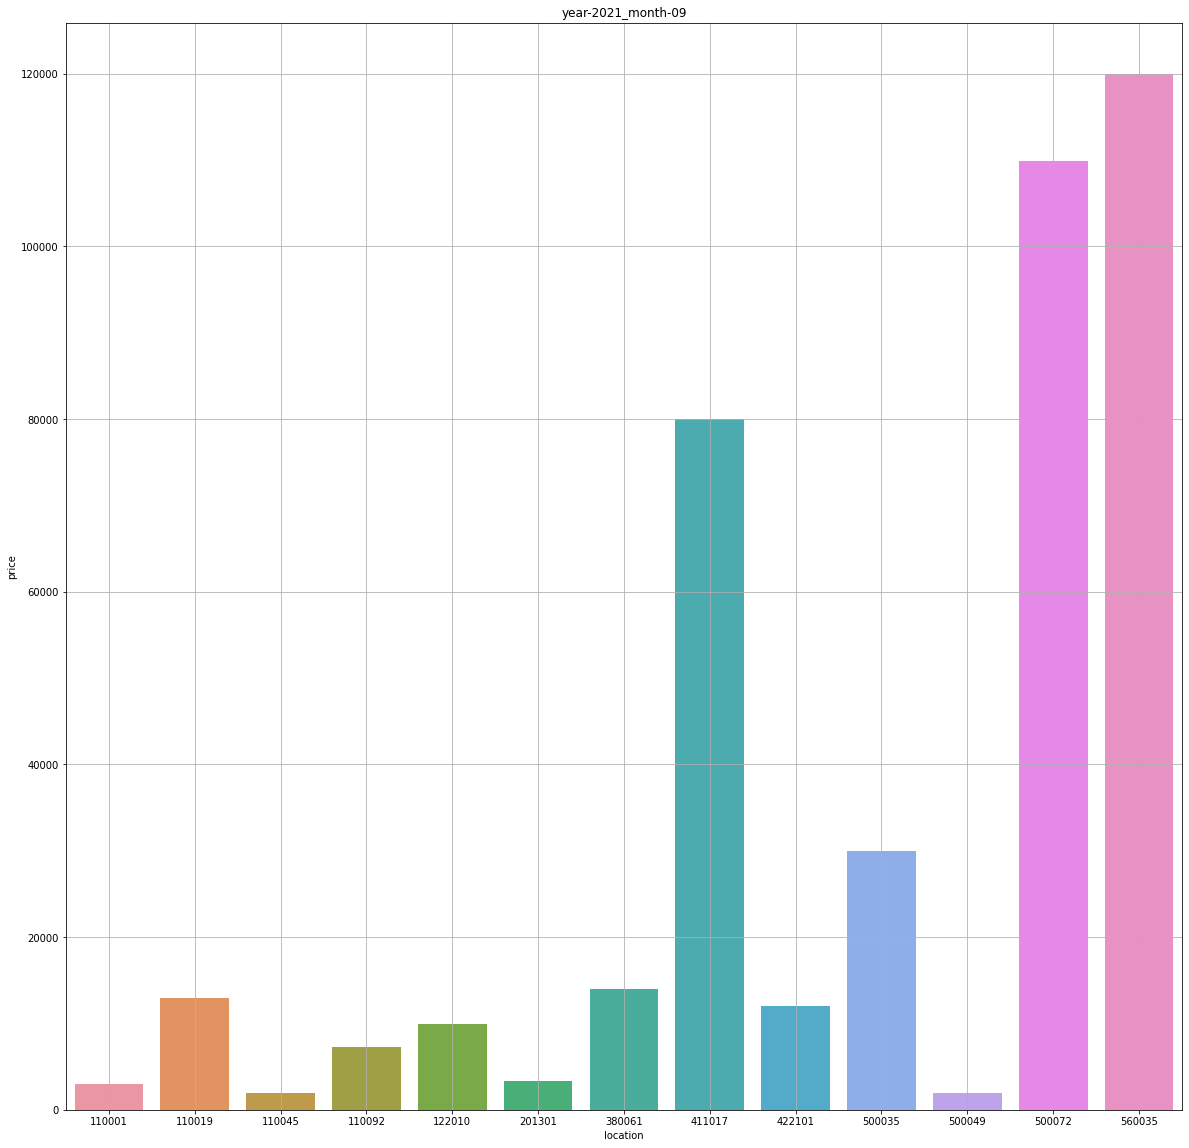

In [19]:
test = final_df[4]
a = test['price']
b = test['location']
plt.figure(figsize=(20,20))
g =sns.barplot(x=b, y=a, data=test, ci=None).set(title=test['Time'][0])
plt.grid()

### Octoober month sales analysis

In [60]:
test = final_df[5]
a = test.groupby('payment_mode')['payment_mode'].count()
print(a)
test = final_df[5]
a = test.groupby(['payment_mode','location'])
a.first()

payment_mode
 Credit Card                        36
 Debit Card                          6
 EMI                                 4
 GiftCard/Voucher                    1
 GiftCard/Voucher / Credit Card     13
 GiftCard/Voucher / Debit Card       2
 GiftCard/Voucher / UPI              1
 GiftCard/Voucher / WALLET           1
 NetBanking                          1
 Pay by UPI                          7
 Pay on Delivery                     1
 Tata Pay                            7
 Wallet                              3
Name: payment_mode, dtype: int64


product_name  \
payment_mode                     location                                                      
 Credit Card                     110033          Samsung Galaxy M11 (Black, 64 GB, 4 GB RAM)   
                                 110058    OnePlus Nord CE 5G (128GB ROM, 8GB RAM, Charco...   
                                 148105    HP Smart Tank 516 Wireless Color All-in-One In...   
                                 201301    Apple Airpods Pro In-Ear Active Noise Cancella...   
                                 201306    Apple 1 Meter USB 2.0 (Type-A) to Lightning Po...   
                                 201308    Onsitego 2 Year Extended Warranty for Home The...   
                                 226020    LG 45 Litres 2 Star Direct Cool Single Door Re...   
                                 242001    Apple iPhone 13 Pro (256GB ROM, 6GB RAM, MLVP3...   
                                 247001    Samsung Q800A 3.1.2 Channel 330 Watts Dolby At...   
                                 302017    Tp-Link AC1200 Dual Band Wireless Router (Arch...   
                                 382345           Samsung Galaxy M11 (Blue, 64 GB, 4 GB RAM)   
                                 382350    Samsung Galaxy M11 (64GB ROM, 4GB RAM, SM-M115...   
                                 382470     Redmi 9 (64GB ROM, 4GB RAM, MZB07RMIN, Sky Blue)   
                                 382475           Samsung Galaxy M11 (Blue, 64 GB, 4 GB RAM)   
                                 400022    Apple Earpods In-Ear Earphones with Mic (With ...   
                                 400037    Apple Airpods Pro In-Ear Truly Wireless Earbud...   
                                 400065    Xiaomi Redmi Note 10 Pro (128GB ROM, 8GB RAM, ...   
                                 400101    Realme Buds Air 2 In-Ear Active Noise Cancella...   
                                 462023    Apple iPad WiFi iOS Tablet (iPadOS 15, Apple A...   
                                 482008    Redmi 9A (32GB ROM, 3GB RAM, MZB9878IN, Midnig...   
                                 500061    Apple In-Ear Wired Earphones with Mic (MNHF2ZM...   
                                 502032    Apple In-Ear Wired Earphones with Mic (MNHF2ZM...   
                                 560061    Apple Airpods Pro In-Ear Active Noise Cancella...   
                                 560064    Kuvings 240 Watts 1 Blade Cold Press Slow Juic...   
                                 560097    Aquaguard Neo UV + UF + MC Electrical Water Pu...   
 Debit Card                      201301    Lenovo G27-20 68.5cm (27 Inches) Full HD IPS S...   
                                 362001    Apple iPhone 12 Mini (64GB ROM, 4GB RAM, MGE23...   
                                 394115       Bose SoundLink Micro Bluetooth Speaker (Black)   
                                 400037    Samsung 7 Series 138cm (55 Inch) Ultra HD 4K L...   
 EMI                             452014    Apple iPad mini 6 WiFi iPadOS Tablet (iPadOS 1...   
                                 500009    Xiaomi Mi TV 5X 108cm (43 Inch) Ultra HD 4K LE...   
                                 500084    Apple iPhone 12 (128GB ROM, 4GB RAM, MGJF3HN/A...   
                                 560085    Atomberg Renesa Smart Plus 120cm Sweep 3 Blade...   
 GiftCard/Voucher                500084    Apple 20 Watt USB-C Power Adapter (MHJD3HN/A, ...   
 GiftCard/Voucher / Credit Card  160062    Boat Rockerz255R In-Ear Wireless Earphones wit...   
                                 400005    Amazfit GTS 2 Mini Smart Watch (GPS) (Always-o...   
                                 400092    Apple iPhone 11 (64GB ROM, 4GB RAM, MHDA3HN/A,...   
                                 440033    Samsung Q950A 11.1.4 Channel 616 Watts Dolby A...   
                                 768111      Kent 20 Litres Water Purifier (Gold Plus, Blue)   
 GiftCard/Voucher / Debit Card   500050    Elica 4 Burner Glass Gas Stove (Brass Burner, ...   
 GiftCard/Voucher / UPI          452005    Dell 

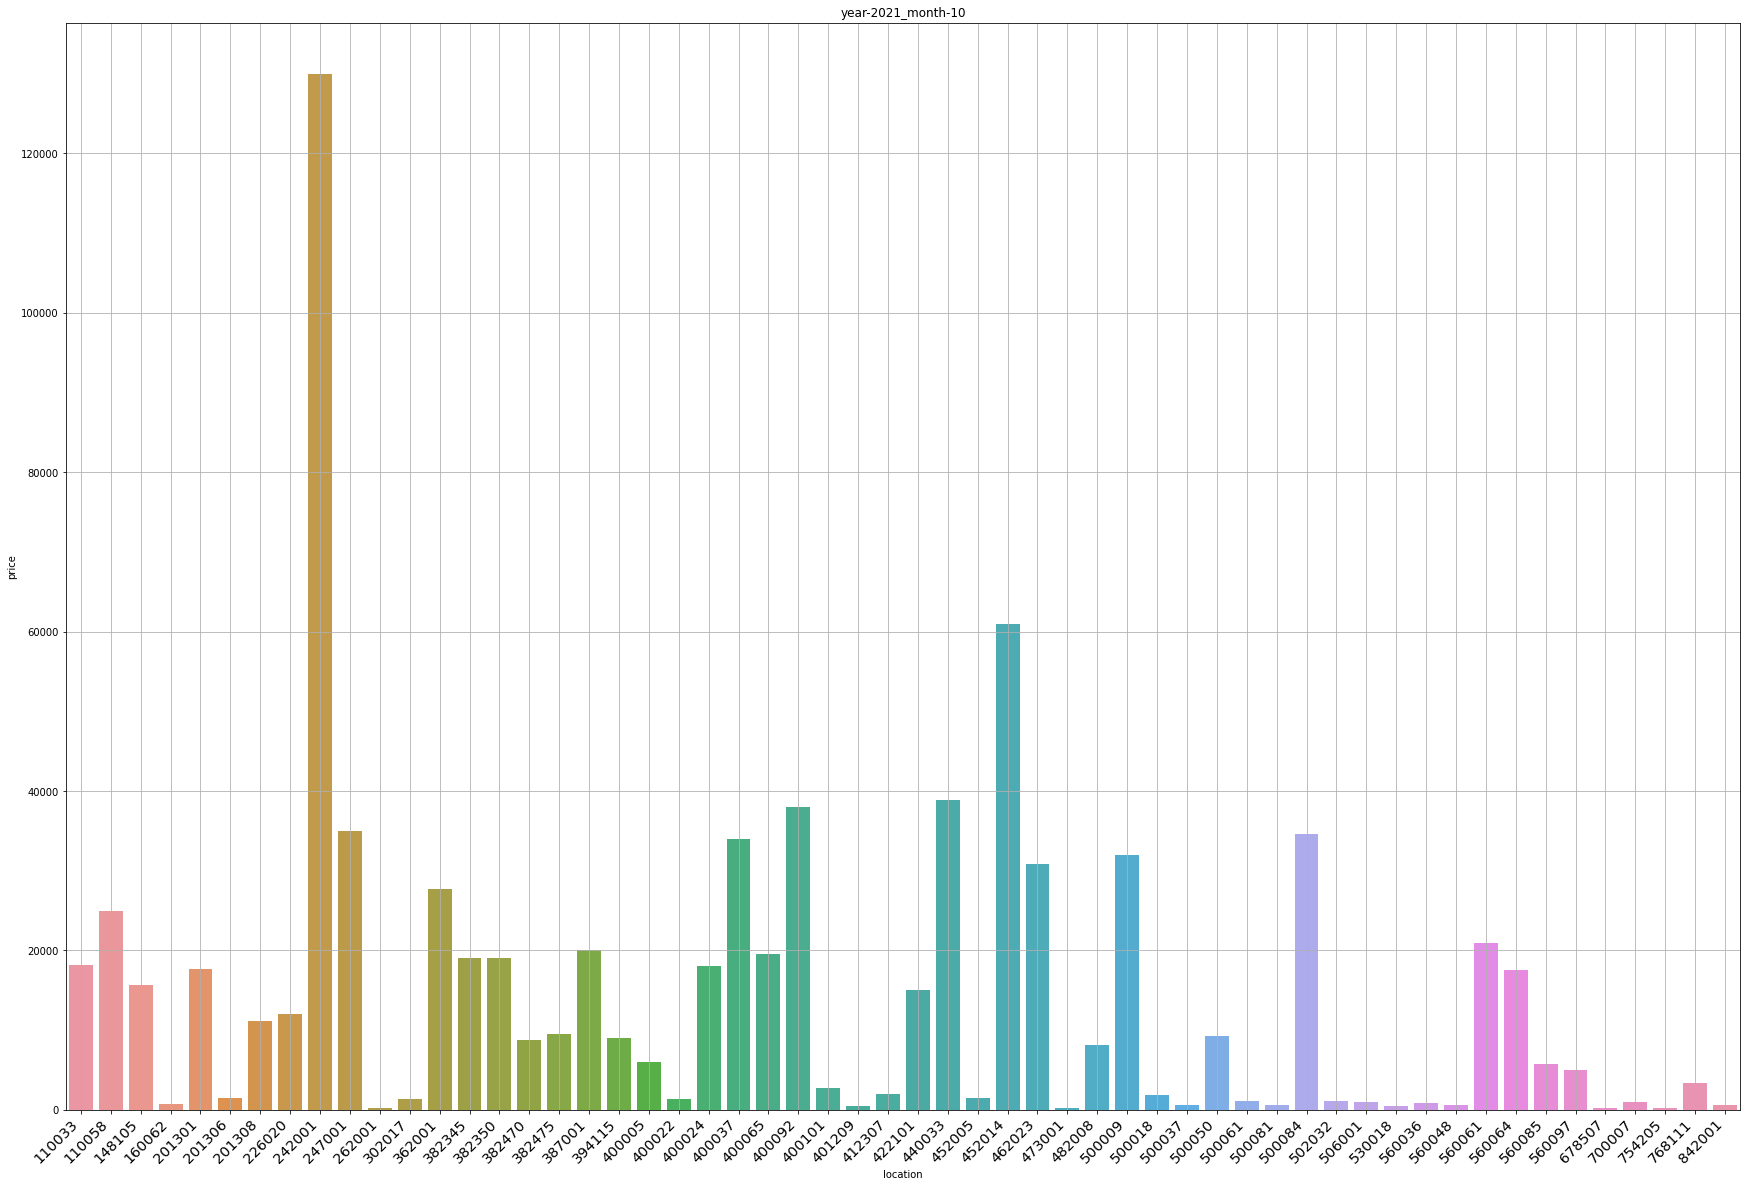

In [20]:
test = final_df[5]
a = test['price']
b = test['location']
plt.figure(figsize=(30,20))
g =sns.barplot(x=b, y=a, data=test, ci=None).set(title=test['Time'][0])
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large' )
plt.grid()

### November month sales analysis

In [58]:
test = final_df[6]
a = test.groupby(['payment_mode','location'])
a.first()

product_name  \
payment_mode                     location                                                      
 ${ctx.order.paymentMode}        517501    Kingston DataTraveler Exodia 32GB USB 3.2 Flas...   
 Credit Card                     110014      Realme X7 (128GB ROM, 6GB RAM, RMX2121, Nebula)   
                                 110059    Apple Earpods In-Ear Earphones with Mic (With ...   
                                 110085    Conekt Zeal Proton Pro 10000mAh 2-Port Power B...   
                                 122004    Apple iPad mini WiFi iOS Tablet (iPadOS 15, Ap...   
                                 226020    LG 45 Litres 2 Star Direct Cool Single Door Re...   
                                 302019       Havells Dry Nose & Ear Trimmer (NE6322, Black)   
                                 400037       Havells Dry Nose & Ear Trimmer (NE6322, Black)   
                                 400061    HP L8J89AA 15.6 Inch Laptop Backpack (L8J89AA#...   
                                 400095    HP L8J89AA 15.6 Inch Laptop Backpack (L8J89AA#...   
                                 410206    Samsung 2.1 Channel 300 Watts Dolby Sound Bar ...   
                                 411017    Apple iPhone 11 (128GB ROM, 4GB RAM, MHDJ3HN/A...   
                                 416012    Lenovo Tab M10 (2nd Gen) WiFi + 4G Android Tab...   
                                 500007    Kent Grand Plus RO+UV+UF+TDS Electrical Water ...   
                                 500013    Samsung Galaxy Tab A7 Lite WiFi + 4G Android T...   
                                 500020    LG 7 Kg 5 Star Fully Automatic Top Load Washin...   
                                 500086    LG 7 Kg 5 Star Fully Automatic Top Load Washin...   
                                 600012    Portronics 12D Ruffpad 30.4 cm (11.96 inches) ...   
                                 600017    Philips Spectre 4.1 Litres Electric Air Fryer ...   
                                 690101    Spigen Nitro Force TPU & PC Back Case For iPho...   
 Debit Card                      400057    Croma Bluetooth Speaker With Hook (CRER2107, B...   
                                 400091    OnePlus Bullets Wireless Z Bass Edition In-Ear...   
                                 401303    LG G1 165.1cm (65 Inch) Ultra HD 4K OLED Smart...   
                                 416229    Apple Airpods Pro In-Ear Active Noise Cancella...   
                                 560025    Sennheiser CX 300s In-Ear Wired Earphones (Noi...   
 EMI                             392165    Croma 170 Litres 2 Star Direct Cool Single Doo...   
                                 500055    Sony ILCE-6000Y 24.3 MP Mirrorless Digital SLR...   
                                 600100    Croma Arctic 22 Litres Personal Air Cooler (In...   
 GiftCard/Voucher                380055    OnePlus Nord 2 5G (128GB ROM, 8GB RAM, DN2101,...   
                                 455001    boAt In-Ear Wired Earphones with Mic (BassHead...   
                                 462023    boAt In-Ear Wireless Earphone with Mic (Blueto...   
                                 691333    boAt In-Ear Wired Earphones with Mic (BassHead...   
                                 751010    boAt In-Ear Wired Earphones with Mic (BassHead...   
 GiftCard/Voucher / Credit Card  110025    Lenovo L22e-30 54.61cm (21.5 Inches) Full HD W...   
                                 121009    Havells Aquilla 1000 Watts Dry Iron (GHGDICEO1...   
 GiftCard/Voucher / Debit Card   492001    Xiaomi Redmi 10 Prime (128GB ROM, 6GB RAM, MZB...   
 GiftCard/Voucher / NetBanking   411051     Sony Bluetooth Earphones (WI-XB400/BZ IN, Black)   
 GiftCard/Voucher / UPI          110042    pTron Bass Pods 281 In-Ear Passive Noise Cance...   
                                 560061    Realme Buds 2 Wired Earphones (ACCFKYE2ARGG67W...   
 GiftCard/Voucher / WALLET       444606    OnePlus Bullets Wireless Z Bass Edition In-Ear...   
                                 600053    boAt 

In [59]:
test = final_df[6]
a = test.groupby('payment_mode')['payment_mode'].count()
print(a)

payment_mode
 ${ctx.order.paymentMode}            1
 Credit Card                        23
 Debit Card                          5
 EMI                                 3
 GiftCard/Voucher                    8
 GiftCard/Voucher / Credit Card      4
 GiftCard/Voucher / Debit Card       1
 GiftCard/Voucher / NetBanking       1
 GiftCard/Voucher / UPI              2
 GiftCard/Voucher / WALLET           2
 NetBanking                          2
 Pay by UPI                          8
 Tata Pay                            2
 Wallet                              3
Name: payment_mode, dtype: int64


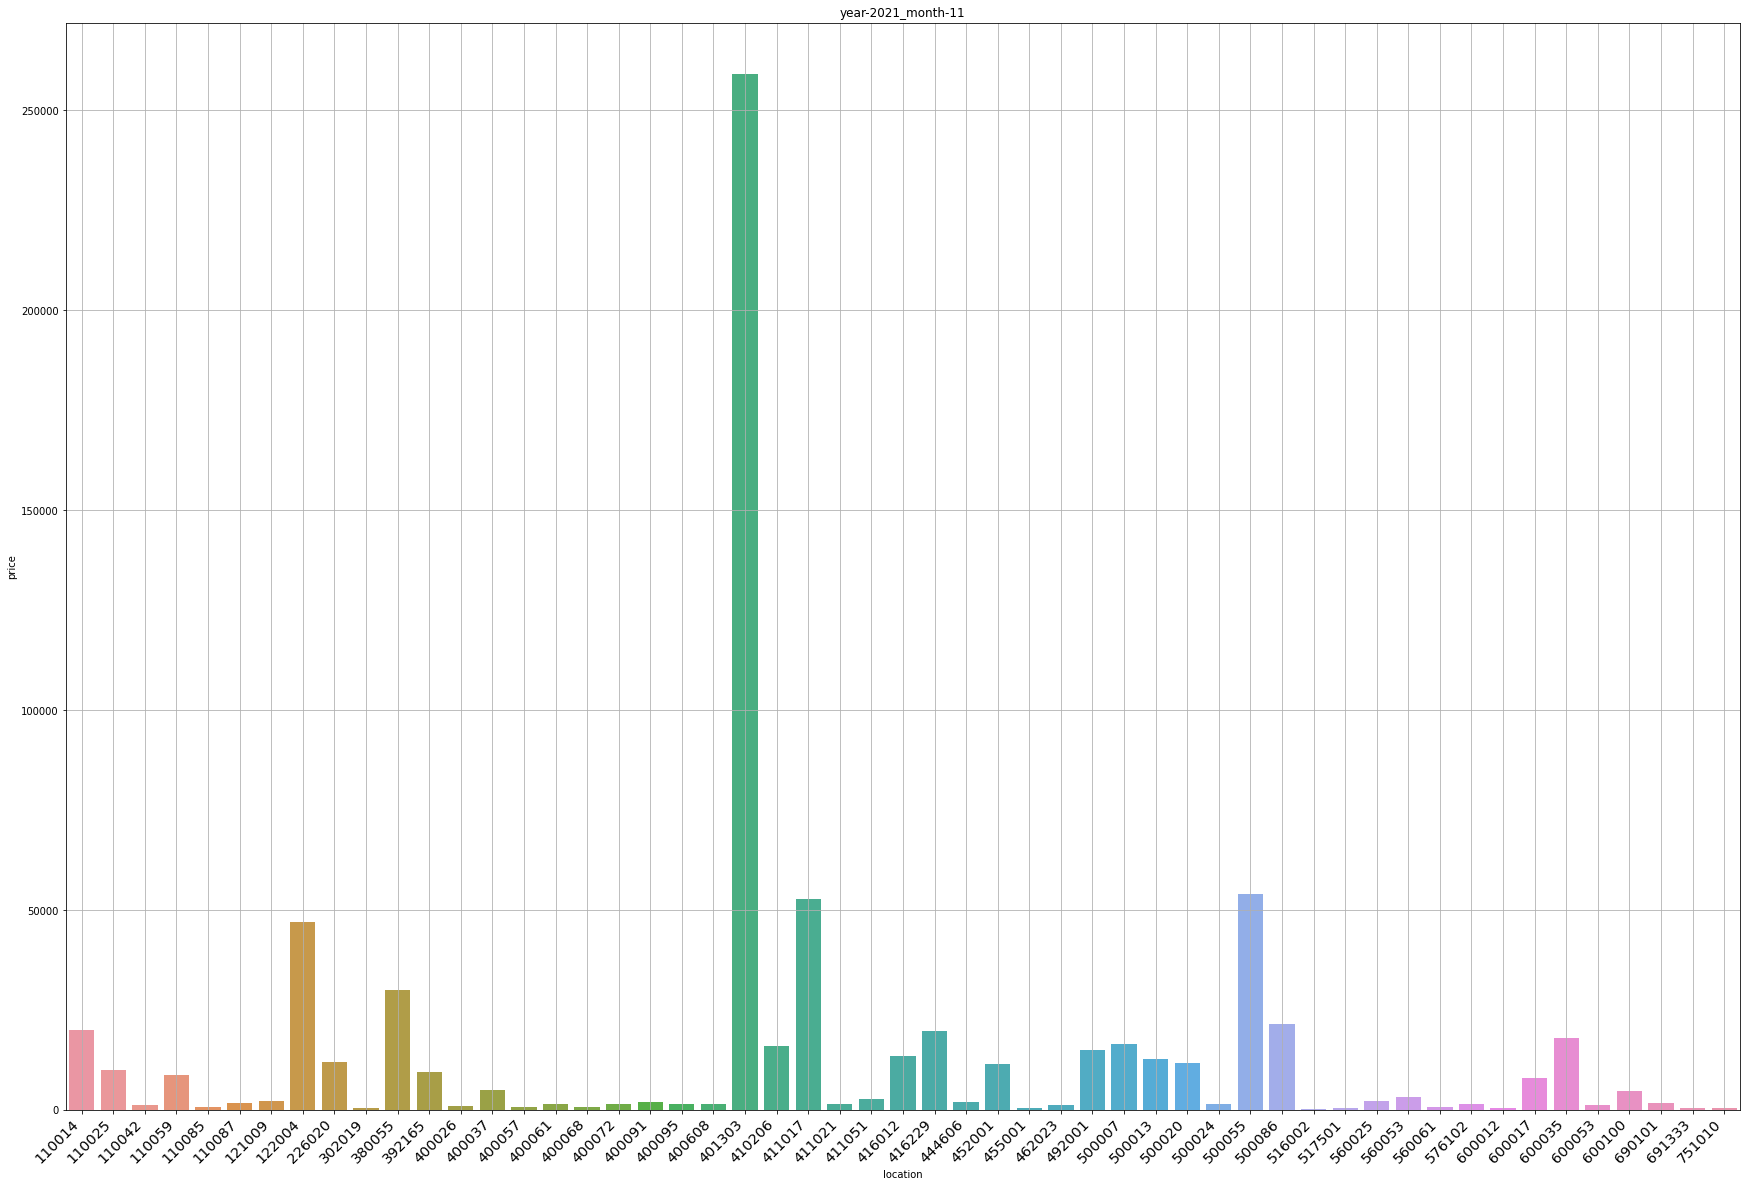

In [21]:
test = final_df[6]
a = test['price']
b = test['location']
plt.figure(figsize=(30,20))
g =sns.barplot(x=b, y=a, data=test, ci=None).set(title=test['Time'][0])
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large' )
plt.grid()

### December month sales analysis

In [44]:
test = final_df[7]
a = test.groupby(['payment_mode','location'])
a.first()

product_name  \
payment_mode                     location                                                      
 Credit Card                     110091    Redmi 9A (32GB ROM, 2GB RAM, MZB9881IN, Nature...   
                                 141013    Apple AirPods 3 In-Ear Truly Wireless Earbuds ...   
                                 201011    Havells Instanio 3 Litres Instant Water Geyser...   
                                 226020    LG 45 Litres 2 Star Direct Cool Single Door Re...   
                                 311001    Samsung Galaxy S21 (128GB ROM, 8GB RAM, SM-G99...   
                                 560015    Apple iPad Pro 11 3rd Gen WiFi iOS Tablet (iPa...   
                                 560099    IFB 25 Litres Convection Microwave Oven (With ...   
 Debit Card                      190001    Redmi 9A (32GB ROM, 2GB RAM, MZB9881IN, Nature...   
                                 560075    Apple iPhone 12 (128GB ROM, 4GB RAM, MGJE3HN/A...   
                                 600094    Spigen Ultra Hybrid Case For Apple Watch Serie...   
 EMI                             122015    OnePlus Nord 2 5G (256GB ROM, 12GB RAM, DN2101...   
                                 452006    Xiaomi Redmi Note 10 Prime (128GB ROM, 6GB RAM...   
 GiftCard/Voucher                124507                   Usha Sandwich Maker (ST1XG, Steel)   
                                 301001    I KALL Lighting Mono 5 Watts Portable Speaker ...   
                                 380055    Samsung Galaxy M11 (64GB ROM, 4GB RAM, SM-M115...   
                                 576102    boAt Airdopes 138 In-Ear Truly Wireless Earbud...   
 GiftCard/Voucher / Credit Card  110062    Noise ColorFit Pro 2 Smart Watch (33mm) (Custo...   
                                 324001    Bajaj Majesty 1000 Watt Dry Iron (MajestyDX6, ...   
                                 431001                  Nokia 105 (4MB ROM, 4MB RAM, Black)   
                                 440033    SanDisk Ixpand 15 Watts Wireless Charging Pad ...   
 GiftCard/Voucher / UPI          322201    Lenovo Slim Everyday 18 Litres Polyester Backp...   
 NetBanking                      841301    HP DeskJet 2729 Wireless Color All-in-One Inkj...   
 Pay by UPI                      110012    boAt Rockerz On-Ear Wireless Headphones (610, ...   
                                 110077    Philips 3000 Series 3 Setting Hair Dryer (Fold...   
                                 400058    Swiss Military 42 Litres Trolley Bag (HTL82, B...   
                                 400092    Syska DualEdge Dry Nose & Ear Trimmer (NT1000,...   
                                 411019    XP-Pen Deco Digital Pad for Desktop, Laptop, i...   
                                 500018    Sony Playstation 5 825GB SSD (CFI-1008A01R, Wh...   
                                 560061    Sony Sport Open-Ear Wired Earphone (Splash-Pro...   
 Wallet                          400026                Samsung Guru 1200 (Black, 153 MB RAM)   
                                 422101    Croma Fire TV 80cm (32 Inch) HD Ready LED Smar...   

                                           qty    price                Time  
payment_mode                     location                                    
 Credit Card                     110091      2  14598.0  year-2021_month-12  
                                 141013      1  17200.0  year-2021_month-12  
                                 201011      1   3669.0  year-2021_month-12  
                                 226020      2  13980.0  year-2021_month-12  
                                 311001      1  59990.0  year-2021_month-12  
                                 560015      1  69490.0  year-2021_month-12  
                                 560099      1  12890.0  year-2021_month-12  
 Debit Card                      190001      1   7599.0  year-2021_month-12  
                                 560075      1  68900.0  year-2021_month-12  
                                 600094      1    890

In [56]:
test = final_df[7]
a = test.groupby('payment_mode')['payment_mode'].count()
print(a)

payment_mode
 Credit Card                        11
 Debit Card                          5
 EMI                                 2
 GiftCard/Voucher                    8
 GiftCard/Voucher / Credit Card      4
 GiftCard/Voucher / UPI              1
 NetBanking                          1
 Pay by UPI                          7
 Wallet                              5
Name: payment_mode, dtype: int64


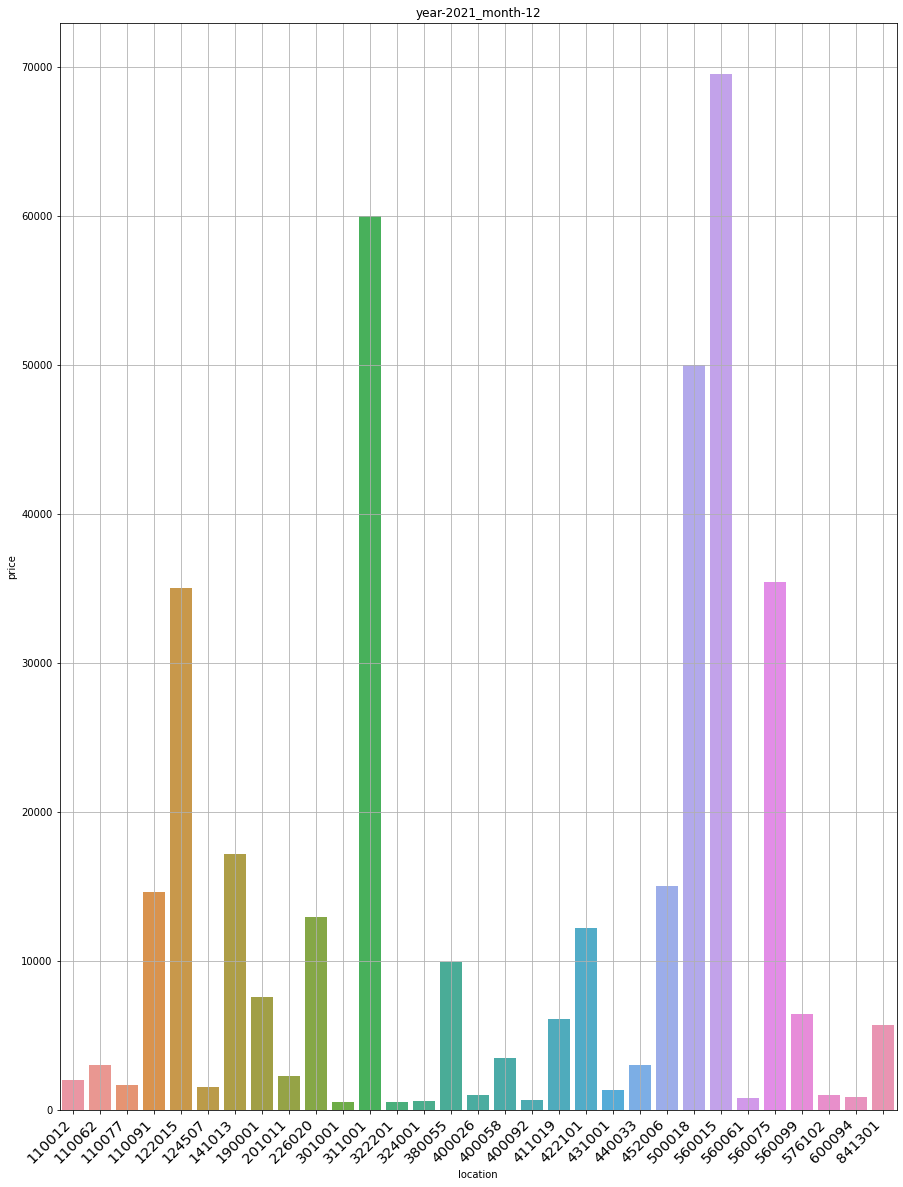

In [22]:
test = final_df[7]
a = test['price']
b = test['location']
plt.figure(figsize=(15,20))
g =sns.barplot(x=b, y=a, data=test, ci=None).set(title=test['Time'][0])
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large' )
plt.grid()

### January month sales analysis

In [31]:
test = final_df[8]
a = test.groupby('payment_mode')['payment_mode'].count()

In [48]:
test = final_df[8]
a = test.groupby(['payment_mode','location'])
a.first()

product_name  \
payment_mode                     location                                                      
 Credit Card                     110059    Boompods Boombuds X Wireless Earbuds (BP-BBUDX...   
                                 110092    Boat Partypal 23 15 Watts Party Speaker (Karao...   
                                 110093    iFFALCON F52 80cm (32 Inch) HD Ready LED Andro...   
                                 122002    Logitech MK345 Wireless Keyboard & Mouse Combo...   
                                 226020    LG 45 Litres 2 Star Direct Cool Single Door Re...   
                                 342008    Croma On-Ear Wireless Headphone with Mic (Blue...   
                                 360005    Philips StyleCare Essential Hair Straightening...   
                                 382350    Xiaomi Redmi Note 10S (64GB ROM, 6GB RAM, MZB0...   
                                 400064    Beurer Pulse Oximeter (XL Colour Display, PO80...   
                                 421302    Realme C21Y (64GB ROM, 4GB RAM, RMX3261, Cross...   
                                 560026    Samsung Galaxy Tab S6 Lite WiFi Android Tablet...   
                                 560040    Lenovo Yoga Smart Tab WiFi + 4G Android Tablet...   
                                 560077    Bosch Serie 4 6 kg 5 Star Fully Automatic Fron...   
                                 560114    Haier 20 Litres Convection Microwave Oven (HIL...   
                                 580021    Dettol No-Touch Automatic Handwash Refill (250...   
                                 626101    Lenovo IdeaPad Flex 3 Chromebook 11IJL6 Celero...   
 Debit Card                      209728    Vivo V23 Pro 5G (128GB ROM, 8GB RAM, V2132, Su...   
                                 560103    Croma 50 Litres 2 Star Direct Cool Reversible ...   
 EMI                             411041    Aquaguard Neo UV + UF + MC Electrical Water Pu...   
                                 600082    Voltas Beko 339 Litres 2 Star Frost Free ProSm...   
                                 751010         Apple iPhone 13 (256GB ROM, MLQA3HN/A, Blue)   
                                 752001    Apple iPhone 13 (128GB ROM, MLPJ3HN/A, (Produc...   
 GiftCard/Voucher                400606    VIP Argo 45 Litres Polycarbonate Trolley Bag (...   
 GiftCard/Voucher / Credit Card  380007    Havells Hexo 1000 Watts 3 Jars Juicer Mixer Gr...   
                                 380055    OnePlus Nord 2 5G (128GB ROM, 8GB RAM, DN2101,...   
                                 752001    Apple AirPods 3 In-Ear Truly Wireless Earbuds ...   
 GiftCard/Voucher / Debit Card   474001    Lenovo Slim Everyday 18 Litres Polyester Backp...   
                                 500039    Western Digital Elements 1.5 TB External Hard ...   
 GiftCard/Voucher / UPI          500050    Borosil Klip-N-Store 520 ml Square Storage Con...   
 NetBanking                      490006    Spigen Neoflex Screen Protector for Samsung Ga...   
                                 600126    boAt Airdopes 138 In-Ear Truly Wireless Earbud...   
 Pay by UPI                      110001    Croma Kube 5 Watts Portable Bluetooth Speaker ...   
                                 226016    Xiaomi Mi Smart Band 6 (Bluetooth, 39.62mm) (P...   
                                 382016                Usha IC3616 Induction Cooktop (Black)   
                                 400017    boAt In-Ear Truly Wireless Earbuds with Mic (B...   
                                 400060    Apple 1 Meter USB 2.0 (Type-A) to Lightning Po...   
                                 400078      Xiaomi Mi 4C Wireless Router (DVB4211IN, White)   
                                 410206    Dettol No-Touch Automatic Handwash Refill (250...   
                                 500076    XP-Pen Star Graphic Tablet for Desktop, Laptop...   
                                 560042    Dettol No-Touch Automatic Handwash Refill (250...   
                                 560056    Targu

In [55]:
test = final_df[8]
a = test.groupby('payment_mode')['payment_mode'].count()
print(a)

payment_mode
 Credit Card                        20
 Debit Card                          3
 EMI                                 4
 GiftCard/Voucher                    2
 GiftCard/Voucher / Credit Card      6
 GiftCard/Voucher / Debit Card       2
 GiftCard/Voucher / UPI              1
 NetBanking                          2
 Pay by UPI                         13
 Tata Pay                            4
 Wallet                             11
Name: payment_mode, dtype: int64


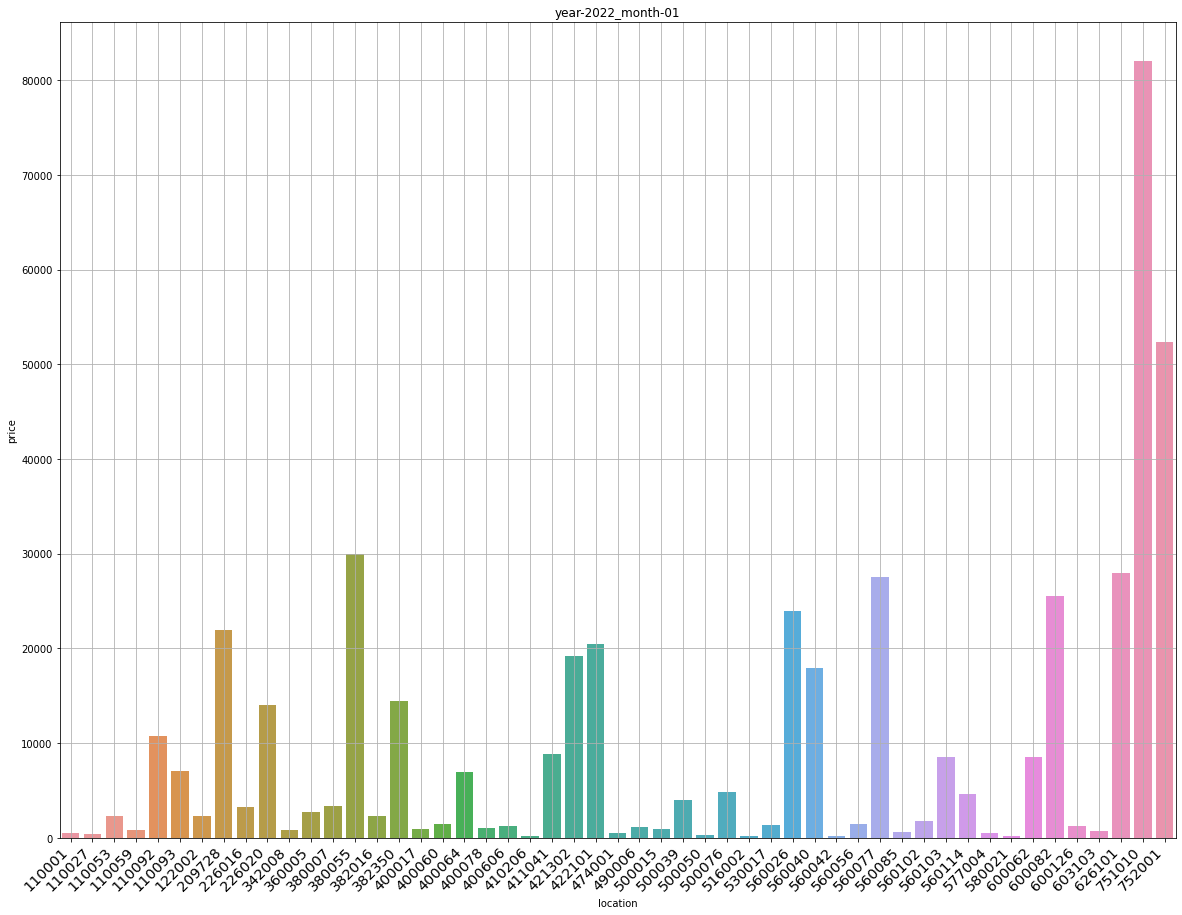

In [23]:
test = final_df[8]
a = test['price']
b = test['location']
plt.figure(figsize=(20,15))
g =sns.barplot(x=b, y=a, data=test, ci=None).set(title=test['Time'][0])
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large' )
plt.grid()

## Use cases for apply machine learining on the dataset

From this dataset, we get inflammation about the consumer shopping habits and, from which particular location more people are purchasing from the website, their payment methods to analyze the type of consumer. In this dataset, we can explore that more consumers are utilizing credit cards and UPI payment methods. From the monthly sales data analysis, more peoples are interested in buying stuff during the Indian festivals in October. During the Diwali festival, more people buy their property from various locations. During the off-season, most of the tear-one and tear-two city people are buying online.

Further, this data can be utilized for the time series analysis to analyze in which month and location people purchase stuff. From this predictive information, the online store can buy their goods from the industry at a lower price and store; During the festive and pick demand, they can sell these goods, earn good profits, and provide better customer service by delivering on time.

For a better product prediction analysis, first, the NER-based NLP method is needed to collect more information about the product name and most repetitive brands, which consumers like to purchase more often. Based on this information machine learning model can be developed. For example, more people are buying AC and Refrigerators during the summer season. So based on the time-series analysis, we can understand which brand product was on hot sell the previous year. Based on this information, shopping website organization can order and purchases item in advance at a lower price, and during the season, they can sell at a reasonable price. Their profit margin will be on the higher side.